# Spectra for DES Y3

In this notebook we would like to check the Limber approximation for the galaxy clustering angular power spectra of DES Y3.

Below we will also explore a CMB lensing cross-correlation example from Advanced ACT survey DR6 release. 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

In [3]:
import numpy as np

from angularcls import limberprojecting as limberp, nonlimberprojecting as nonlimberp

import dynamic_yaml as yaml

import pathlib

## Load Configuration

In [6]:
configuration_dir = pathlib.Path("inputs")
with open(configuration_dir / "configuration.yaml") as f:
    config = yaml.load(f)

cosmology = config["cosmology"]

analysis = config["analysis"]
lmin, lmax = analysis["lmin"], analysis["lmax"]
ls = np.arange(lmin, lmax + 1)

survey = config["surveys"]

maglim = survey["Maglim"]
Nz = maglim["Nz"]
redshift_windows_txt_root = configuration_dir/maglim["redshift_windows_txt_root"]
info_txt_file = configuration_dir/maglim["info_txt_file"]

nzdists = {i: tuple(np.loadtxt(f'{redshift_windows_txt_root}{i}.txt', unpack = True)) for i in range(Nz)}

info = np.genfromtxt(f'{info_txt_file}.txt')
zedges = info[0, :]
Ngals = info[1, :-1]
biases = info[2, :-1]
magbiases = info[3, :-1]


## Process Window Functions

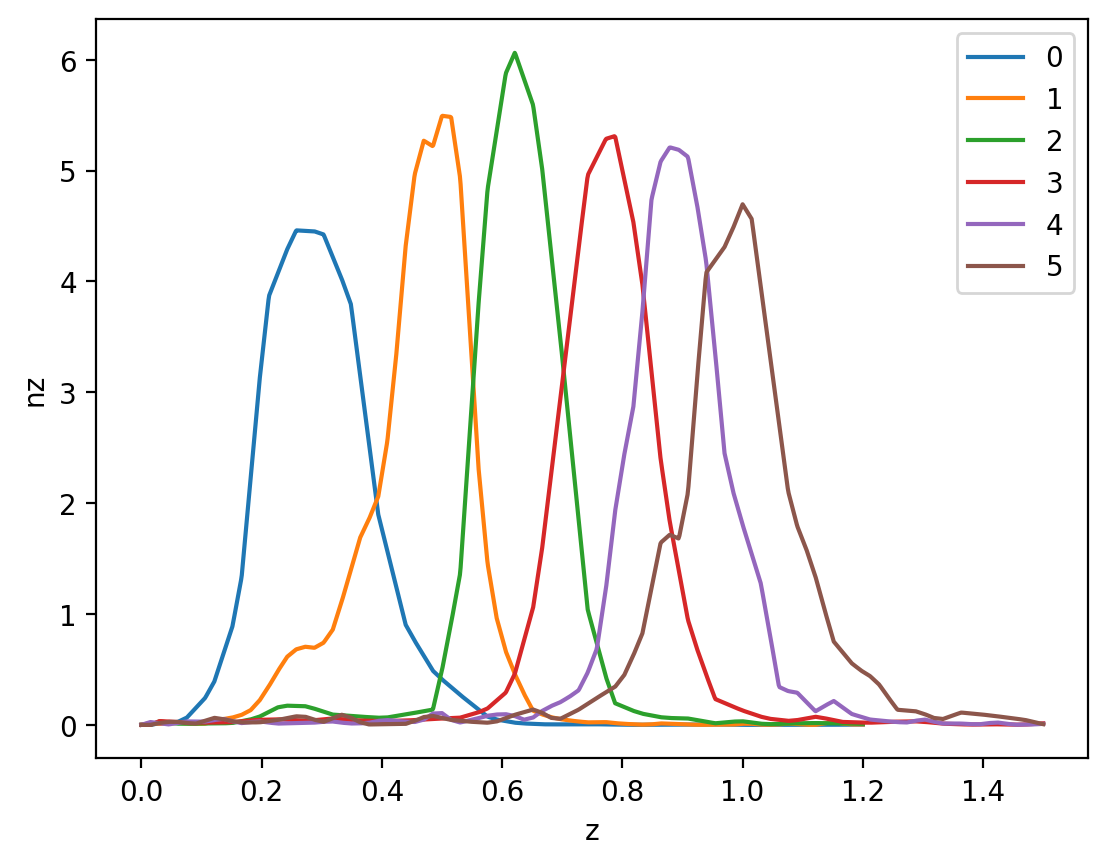

In [7]:
zmin = 1e-8
numzbins = 1000
kbar = 3
#basically to get more stable solutions with camb you want to pay attention to the input nz so that it is well sampled in the range of interest.
#CAMB does this dynamically but I am not sure how and this way does not break things when I get spectra.

nzdists = {k: (np.linspace(zmin, 1.2 if k < kbar else 1.5, numzbins), np.interp(np.linspace(zmin, 1.2 if k < kbar else 1.5, numzbins), v[0], v[1])) for k, v in nzdists.items()}

for k, v in nzdists.items():
    plt.plot(*v, label = k)
plt.legend()
plt.xlabel("z")
plt.ylabel("nz")
plt.show()


## Set CAMB

In [8]:
nonlinearmode = True

In [9]:
import camb
from camb import model as cmodel
from camb import sources as csources

pars = camb.CAMBparams()
h = cosmology["h"]
Omegac, Omegab = cosmology["Omegac"], cosmology["Omegab"]
H0, Omegam = 100*h, (Omegac+Omegab) 
pars.set_cosmology(H0 = H0, ombh2 = Omegab*h**2, omch2 = Omegac*h**2)
As, ns = cosmology["As"], cosmology["ns"]
pars.InitPower.set_params(As = As, ns = ns)

pars.set_for_lmax(lmax, lens_potential_accuracy = 3)

pars.Want_CMB = True 

pars.NonLinear = cmodel.NonLinear_both if nonlinearmode else cmodel.NonLinear_none

pars.SourceWindows = [csources.SplinedSourceWindow(z = nzdists[i][0], W = nzdists[i][1], bias = biases[i], dlog10Ndm = magbiases[i], source_type = 'counts') for i in range(Nz)]


pars.SourceTerms.counts_density = True
pars.SourceTerms.counts_evolve = False
pars.SourceTerms.counts_redshift = False
pars.SourceTerms.counts_lensing = False
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_radial = False
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.limber_windows = True
"""
pars.SourceTerms.limber_windows = False
pars.SourceTerms.limber_phi_lmin = 1
"""

results = camb.get_results(pars)
cls = results.get_source_cls_dict(raw_cl = True)

In [10]:
#pars.NonLinearModel.set_params

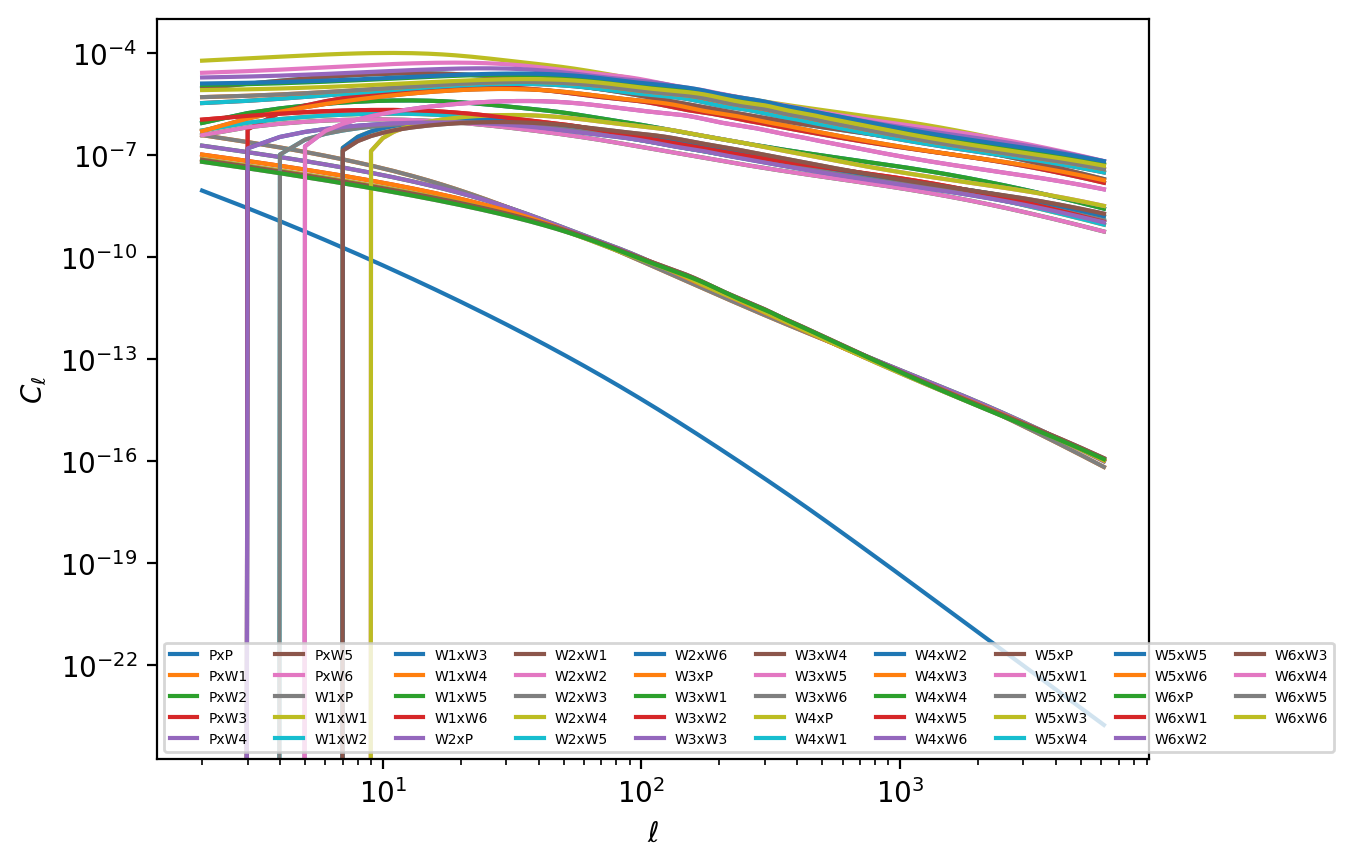

In [11]:
lscamb = np.arange(2, lmax+1)
for spectrum, cl in cls.items():
    p = plt.loglog(lscamb, cl[2:lmax+1], label = spectrum)
#plt.xlim(2, 90)
#plt.ylim(1e-7)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend(ncol = 10, fontsize = 5)

In [66]:
for spectrum, cl in cls.items():
    ls = np.arange(0, len(cl))
    A, B = spectrum.split('x')
    nome = f'/Users/omard/Downloads/ACTXDES-DATA/spectraDESY3/cl_{A}_{B}.txt'
    factor = ls*(ls+1)/(2)
    if A == B:
        if A == 'P':
            factor = factor**2
        else:
            factor = factor
    np.savetxt(nome, np.array([ls, cl*factor]).T)

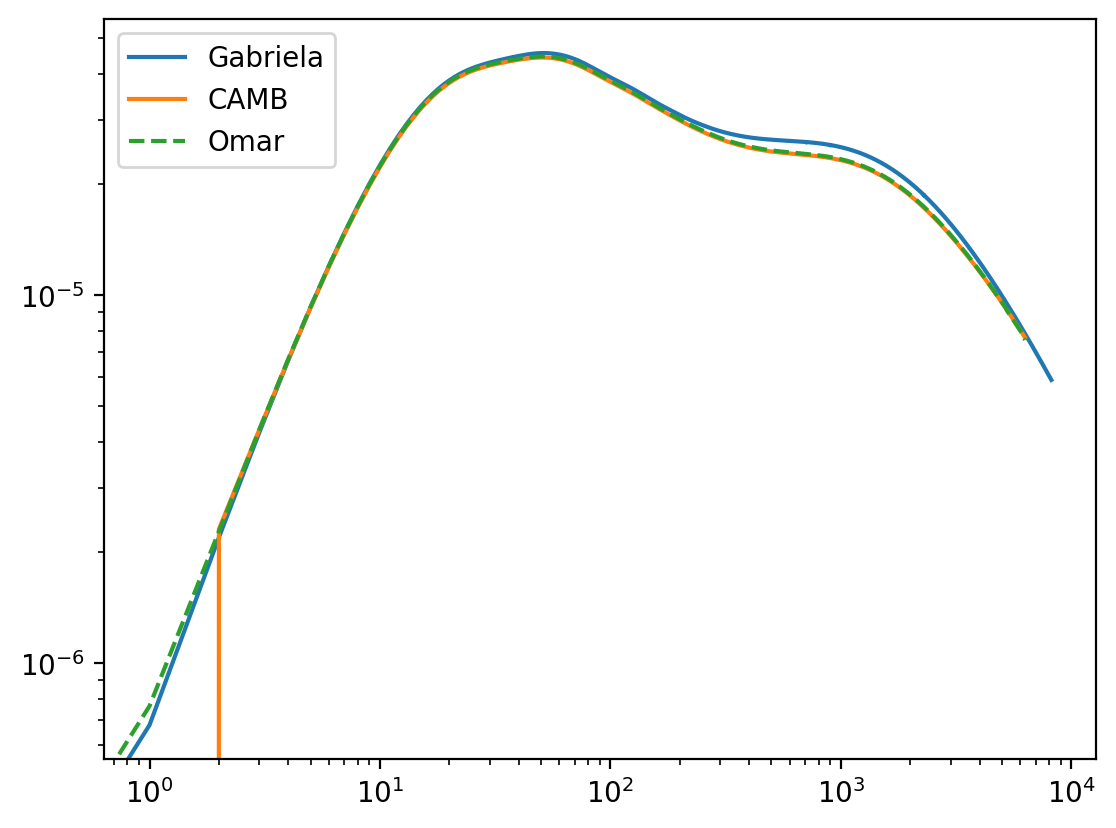

In [80]:
nome = "/Users/omard/Downloads/ACTXDES-DATA/inputgabriela/Clkg_input_z1.dat"
l, g = np.loadtxt(nome, unpack = True)
plt.loglog(l, g*l, label = 'Gabriela')

ls = np.arange(0, len(cls['PxP']))
el, cl = np.loadtxt(f'/Users/omard/Downloads/ACTXDES-DATA/spectraDESY3/cl_P_W1.txt', unpack = True)
plt.loglog(el, el*cl, label = 'CAMB')
plt.loglog(Result.ls, Result.ls*Result.get('g1', 'k'), label = 'Omar', ls = '--')
plt.legend()

## All Limber

In [12]:
import cosmopower as cp

cosmo_power_direc = '/Users/omard/Documents/projects/cosmopower/cosmopower/trained_models/CP_paper/PK/'
k = np.loadtxt(cosmo_power_direc + 'k_modes.txt')

lin_emu = cp.cosmopower_NN(restore=True,
                           restore_filename=cosmo_power_direc+'PKLIN_NN')

nlboost_emu = cp.cosmopower_NN(restore=True,
                               restore_filename=cosmo_power_direc+'PKNLBOOST_NN')

zNNmax = 4.0
z = np.linspace(0, zNNmax, 1000)
h_ = cosmology["h"]*np.ones_like(z)
omega_b = cosmology["Omegab"]*h_**2
omega_cdm = cosmology["Omegac"]*h_**2
n_s = cosmology["ns"]*np.ones_like(z)
lnAs = np.log(1e10*cosmology["As"])*np.ones_like(z)
c_min = 3.13*np.ones_like(z)
eta_0 = 0.603*np.ones_like(z)

batch_params_lin = {'omega_b': omega_b,
                    'omega_cdm': omega_cdm,
                    'h': h_,
                    'n_s': n_s,
                    'ln10^{10}A_s': lnAs,
                    'z': z,
                    }


batch_params_hmcode = {'c_min': c_min,
                       'eta_0': eta_0}

batch_params_nlboost = {**batch_params_lin, **batch_params_hmcode}

total_log_power = lin_emu.predictions_np(batch_params_lin) + nlboost_emu.predictions_np(batch_params_nlboost)
# 10*(log_lin + log_boost)
total_power = 10.**(total_log_power)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-28 08:05:51.489542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 08:05:51.489953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
total_power.shape

(1000, 420)

In [83]:
from angularcls import windows

from scipy import interpolate as sinterp

def gaussxw(a, b, N):
    #get points and weights for Gaussian quadrature using numpy legendre module
    x, w = np.polynomial.legendre.leggauss(N)
    return 0.5*(b-a)*x + 0.5*(b+a), 0.5*(b-a)*w

results = camb.get_results(pars)

kmax = k.max()  #kmax to use


In [84]:

PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1='delta_nonu',var2='delta_nonu', zmax = 1089)

PKlin = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1='delta_nonu',var2='delta_nonu', zmax = 1089)


nzs = 2000
zstar = 1089
chistar = results.comoving_radial_distance(zstar)
chis = np.linspace(0, chistar, nzs)

chis, weights = gaussxw(0, chistar, 100)


In [82]:
zs = results.redshift_at_comoving_radial_distance(chis)

chis = results.comoving_radial_distance(zs)

hubble = results.hubble_parameter(zs)

In [75]:

cmblensingwindow = windows.cmblensingwindow(zs, chis, hubble, H0, Omegam, chistar = chistar)


spectra = [('m', PK.P if nonlinearmode else PKlin.P)]
zmin, zmax = zs.min(), zs.max()
Proj = limberp.LimberProjector(zs, spectra = spectra, ls = ls, kmax = kmax, gaussquadweights = weights)

Hubble, chi = sinterp.interp1d(zs, hubble, fill_value = 0., bounds_error = False), sinterp.interp1d(zs, chis, fill_value = 0., bounds_error = False)

magwindows = [windows.magnificationbiaswindow(magbiases[i], sinterp.interp1d(nzdists[i][0], nzdists[i][1], fill_value = 0., bounds_error = False), hubble, H0, Omegam, zs, chis) for i in range(Nz)]
magwindows = [np.interp(nzdists[i][0], zs, magwindows[i]) for i in range(Nz)]

Ws = [sinterp.interp1d(nzdists[i][0], (nzdists[i][1]*biases[i]+magwindows[i]), fill_value = 0., bounds_error = False) for i in range(Nz)]

galnames = [f'g{i+1}' for i in range(Nz)]

[Proj.update_window(gname, ('m', Ws[i])) for i, gname in enumerate(galnames)]

Proj.update_window('k', ('m', cmblensingwindow))

print('Getting spectra')
excluded_windows_combinations = []
Result = Proj.obtain_spectra(Hubble, chi)

Getting spectra


In [76]:
Proj.ws.shape

(100,)

In [77]:
zs.shape

(100,)

In [78]:
PKNN = sinterp.RegularGridInterpolator((z, k), total_power, fill_value = 0., bounds_error = False)
#PKKNNtotal = np.vectorize(lambda z, k, grid: PKNN((z, k)) if z < zNNmax else PKlin.P(z, k, grid = grid))
def PKKNNtotal(z, k, grid):
    result = np.zeros_like(z)

    indmesh = z < zNNmax

    result[indmesh] = PKNN((z[indmesh], k[indmesh]))
    result[~indmesh] = PKlin.P(z[~indmesh], k[~indmesh], grid = grid)
    
    return result


spectra = [('m', PKKNNtotal)]
ProjNN = limberp.LimberProjector(zs, spectra = spectra, ls = ls, kmax = kmax, gaussquadweights = weights)

[ProjNN.update_window(gname, ('m', Ws[i])) for i, gname in enumerate(galnames)]

ProjNN.update_window('k', ('m', cmblensingwindow))

excluded_windows_combinations = []
ResultNN = ProjNN.obtain_spectra(Hubble, chi)

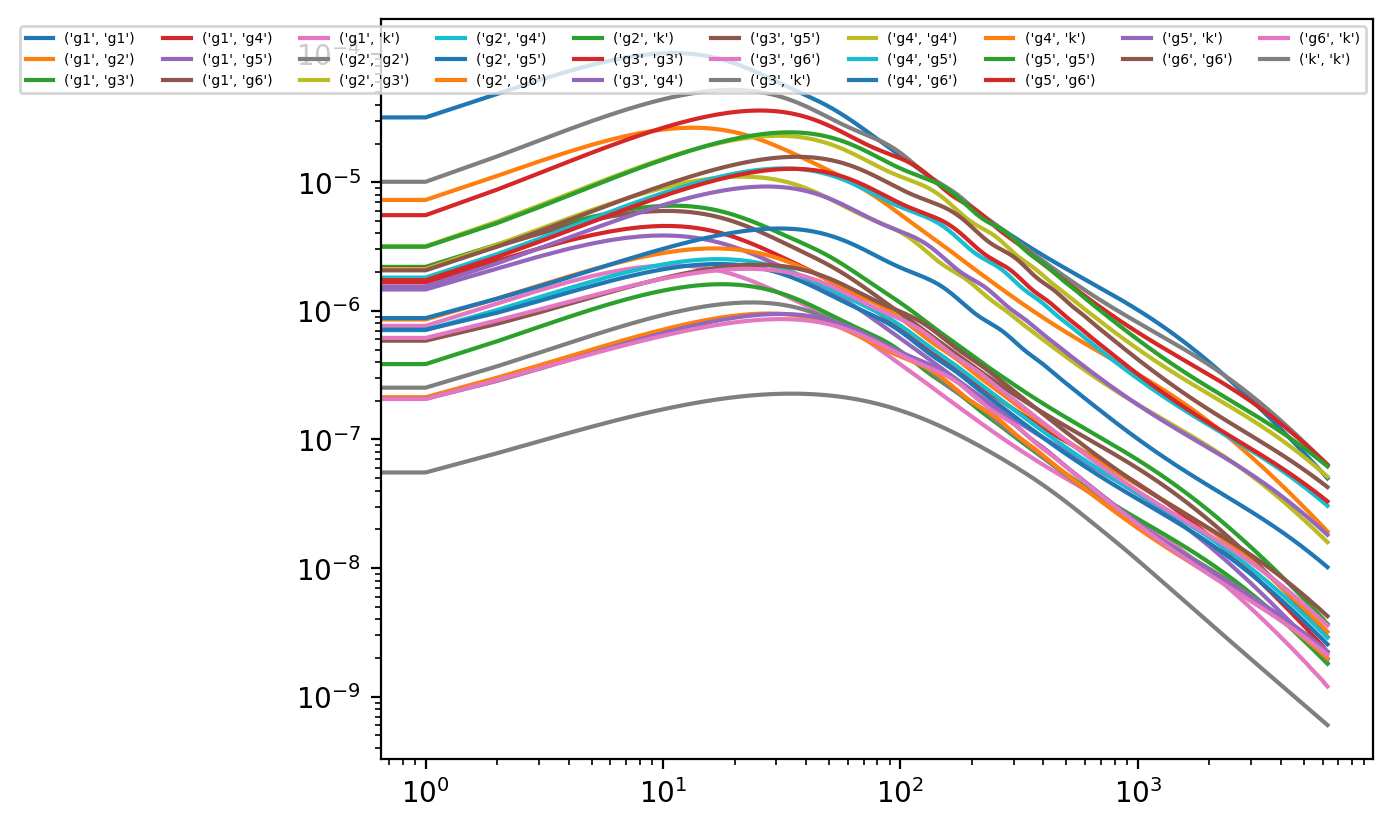

In [79]:
for key in Result.results.keys():
    plt.loglog(ls, Result.results[key], label = key)
plt.legend(ncol = 10, fontsize = 5)

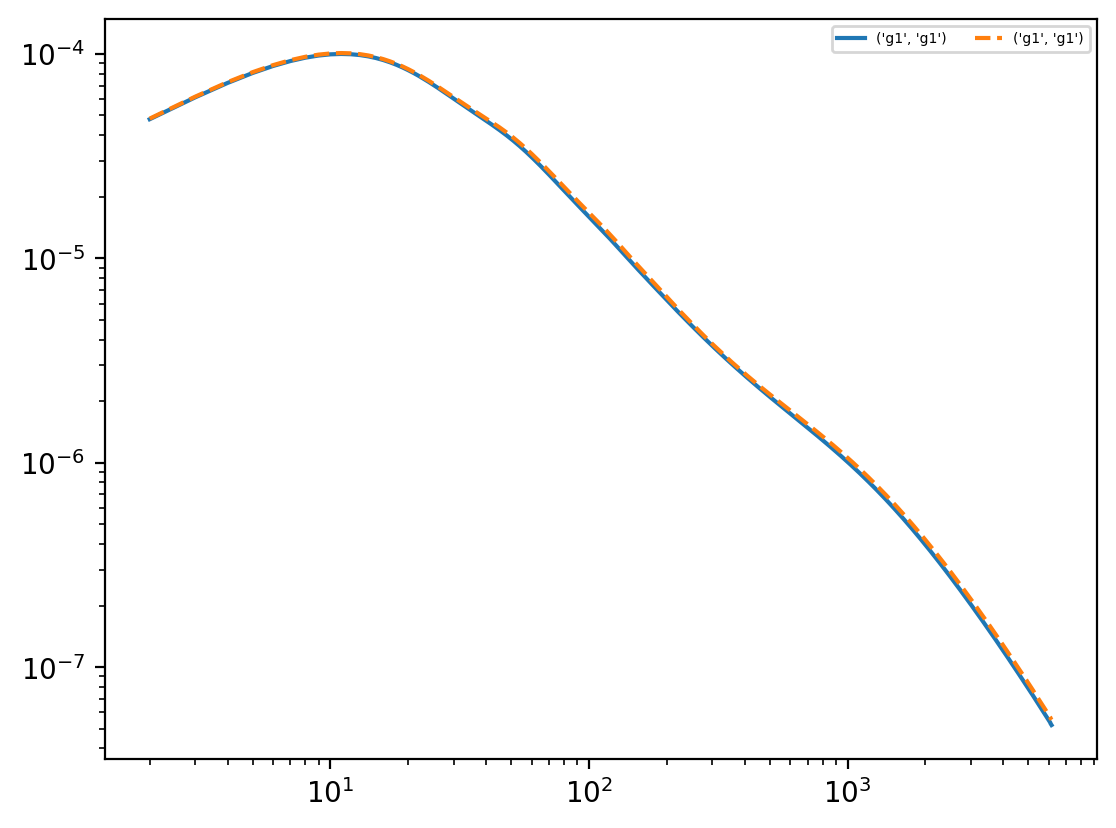

In [59]:
key = ('g1', 'g1')
plt.loglog(ls, Result.results[key], label = key)
plt.loglog(ls, ResultNN.results[key], label = key, ls = '--')
plt.legend(ncol = 10, fontsize = 5)

## FFTlog method

In [88]:
spectra = [('m', PK.P), ('linm', PKlin.P)]
FProj = nonlimberp.FFTlogProjector(zs = zs, spectra = spectra, ls = ls, kmax = kmax)

In [89]:
from angularcls import utils
growth = utils.growth_factor_quick(zs, pars, kmax)

Note: redshifts have been re-sorted (earliest first)


In [90]:
Hz = sinterp.interp1d(zs, hubble, fill_value=0., bounds_error=False)

growthofzs = sinterp.interp1d(zs, growth, fill_value=0., bounds_error=False)

linear_power_interpolator = lambda k: PKlin.P(0, k)
diff_power_interpolator = lambda k: PK.P(0, k) - PKlin.P(0, k)

chi_min, chi_max = results.comoving_radial_distance(0.0002), results.comoving_radial_distance(4)

Pnonlinear = PKlin.P
Pnonlinear = PKKNNtotal


resultspec = {}

for k in Result.results.keys():
    A, B = k
    if A == 'k' or B == 'k':
        continue
    iA, iB = galnames.index(A), galnames.index(B)
    bofzA, bofzB = lambda chi: np.ones_like(chi), lambda chi: np.ones_like(chi) #include biases in W for now, lambda chi: np.ones_like(chi)*biases[iA], lambda chi: np.ones_like(chi)*biases[iB]
    nzzA, nzzB = Ws[iA], Ws[iB]

    resultspec[k] = FProj.integrate(ls, zs, chis, Hz, growthofzs, bofzA, bofzB, nzzA, nzzB, PKlin.P, PK.P if nonlinearmode else Pnonlinear, chi_min, chi_max, num = 2000, miniter = 9000)

1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 1000
1000 4000 

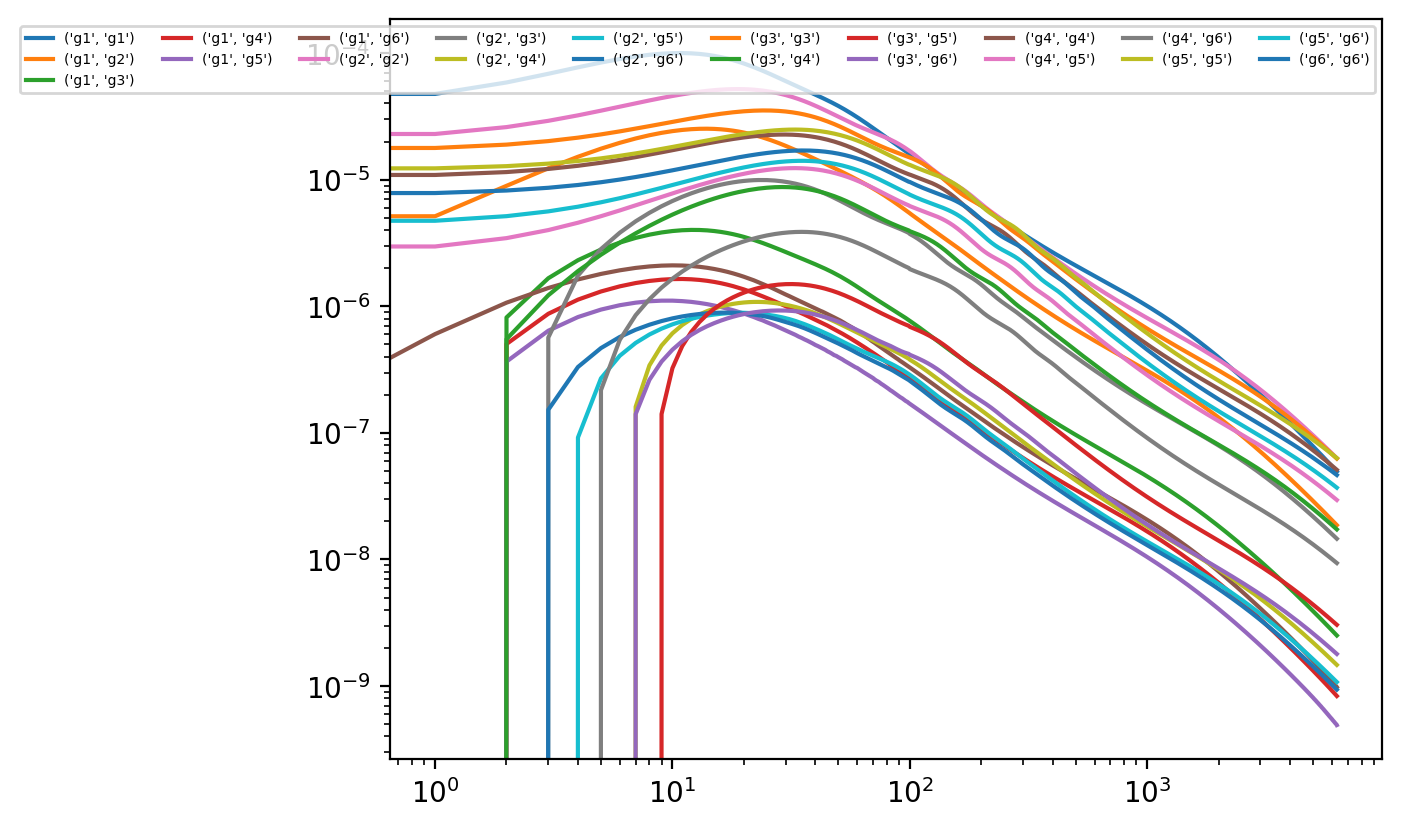

In [91]:
for key in resultspec.keys():
    plt.loglog(ls, resultspec[key], label = key)
plt.legend(ncol = 10, fontsize = 5)

## Compare results

In [92]:
gaussian_errors_simple = lambda l, clA, clB, clAB: np.sqrt(clA*clB+clAB**2)/np.sqrt(2*l+1)

In [95]:
def plot_specific(ax, indexA, indexB):
    key = (galnames[indexA], galnames[indexB])
    ax.loglog(Result.ls, Result.results[key], label = 'Limber')
    ax.loglog(lscamb, cls[f'W{indexA+1}xW{indexB+1}'][2:lmax+1], label = 'Exact')
    ax.loglog(Result.ls, resultspec[key], label = 'FFTlog')
    ax.legend(fontsize = 5)
    ax.set_title(f'{galnames[indexA]} x {galnames[indexB]}')

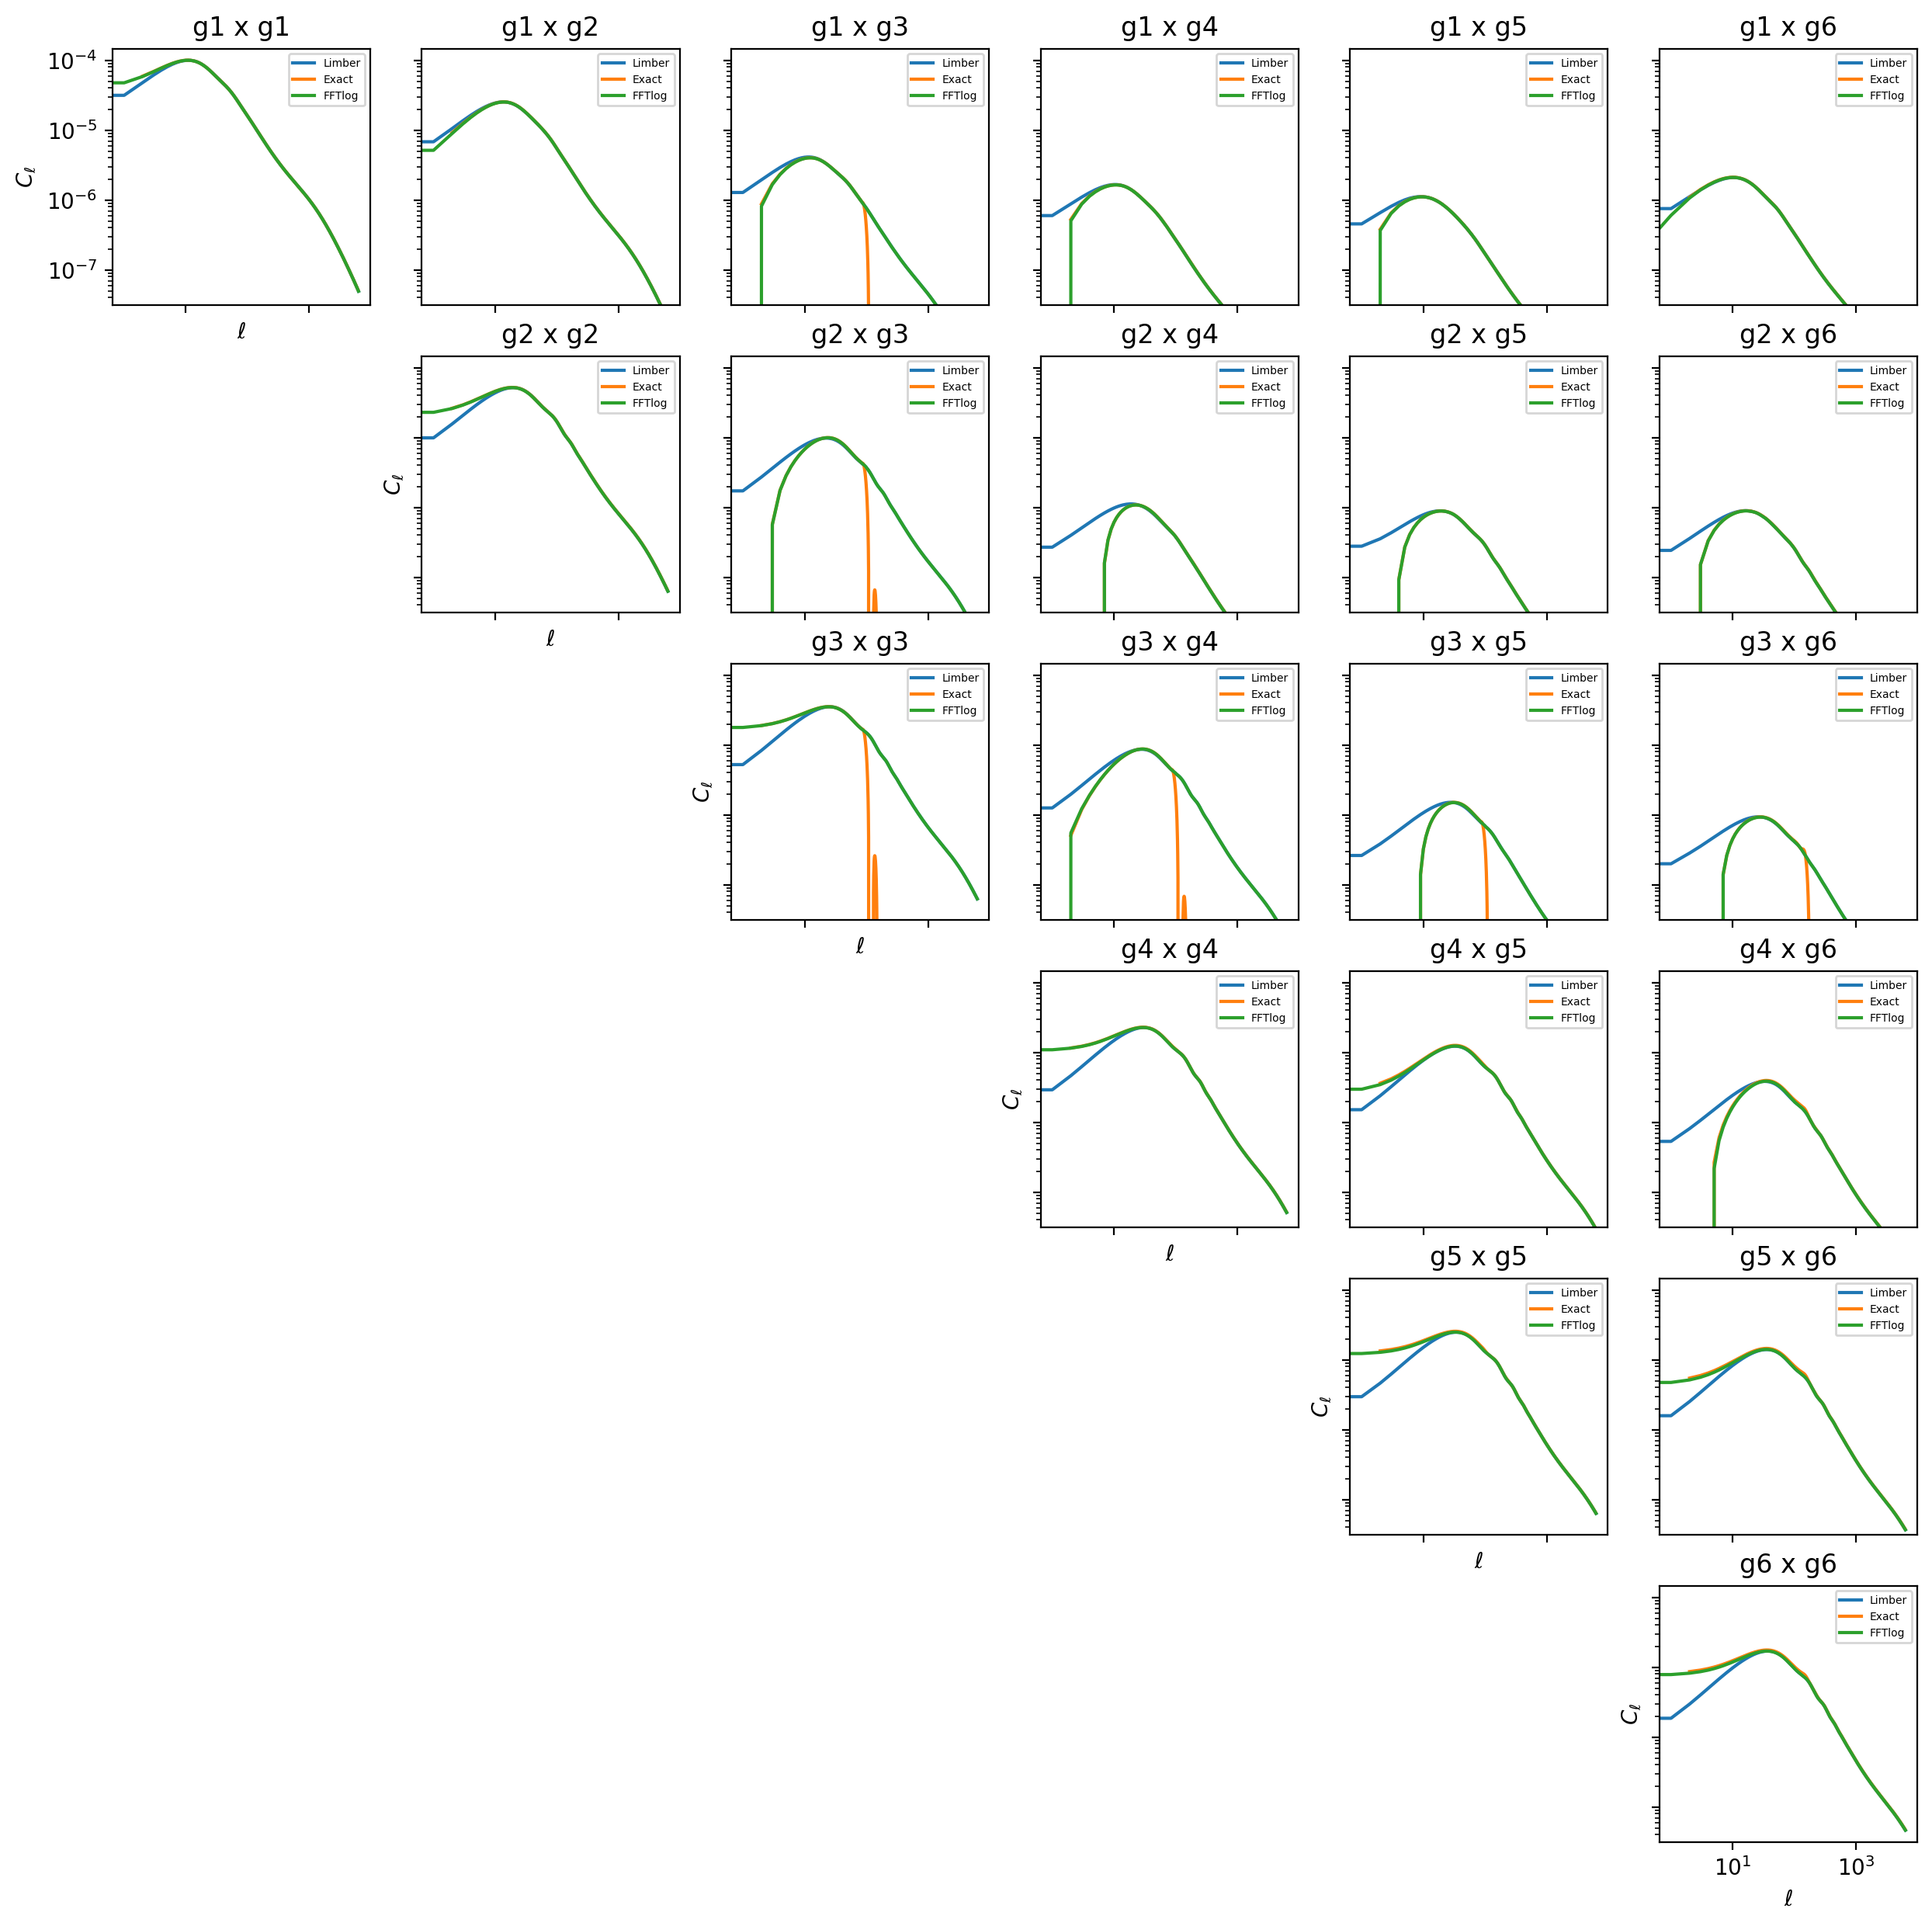

In [96]:
fig, axes = plt.subplots(figsize = (15, 15), sharex = True, sharey = True, ncols = Nz, nrows = Nz)

for i in range(Nz):
    for j in range(Nz):
        if i>j:
            axes[i, j].axis('off')
        else:
            plot_specific(axes[i, j], i, j)
            if i == j:
                axes[i, j].set_ylabel('$C_{\ell}$')
                axes[i, j].set_xlabel('$\ell$')
plt.savefig('desY3check.png', dpi = 300)

## Including Perturbation Theory based modelling